# HIP 65426 - ERS 1386

This program will perform coronagraphic observations of the exoplanet host star HIP 65426 at two separate roll angles. Reference observations will be performed on the nearby star HIP 65219. Each NIRCam observation uses the M335R coronagraphic mask with a range of filters. The SUB320 subarray in addition to the MEDIUM8 pattern have been selected to avoid detector saturation and maximize the achievable SNR. 

This notebook compares the predicted performance from pyNRC simulation to that derived from flight data.

In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting
%matplotlib inline

# Progress bar
from tqdm.auto import trange, tqdm

In [2]:
import pynrc

# Disable informational messages and only include warnings and higher
pynrc.setup_logging(level='WARN')

pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


## Source Definitions

Define science and reference source spectral information and fit model spectra to Vizier photometric data.

In [3]:
# Define 2MASS Ks bandpass and source information
bp_k = pynrc.bp_2mass('k')

# Science      source,  dist, age, sptype, Teff, [Fe/H], log_g, mag, band
args_sci = ('HIP 65426', 107.5, 10,  'A2V', 8840, 0.00, 4.00, 6.77, bp_k)

# References  source,     sptype, Teff, [Fe/H], log_g, mag, band
args_ref = ('HIP 68245', 'B2IV', None, None, None, 4.49, bp_k)

# Directory housing VOTables 
# http://vizier.u-strasbg.fr/vizier/sed/
votdir = '../votables/'

In [8]:
# Fit spectrum to SED photometry
name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci = args_sci
vot = votdir + name_sci.replace(' ' ,'') + '.vot'

args = (name_sci, spt_sci, mag_sci, bp_sci, vot)
kwargs = {'Teff':Teff_sci, 'metallicity':feh_sci, 'log_g':logg_sci}
src = pynrc.source_spectrum(*args, **kwargs)

src.fit_SED(use_err=False, robust=True, wlim=[3,30])

# Final source spectrum (pysynphot)
sp_sci = src.sp_model
# sp_sci = src.sp0

SED best-fit params: [0.99576841]


In [18]:
# Do the same for the reference source
name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = args_ref
vot = votdir + name_ref.replace(' ' ,'') + '.vot'

args = (name_ref, spt_ref, mag_ref, bp_ref, vot)
kwargs = {'Teff':Teff_ref, 'metallicity':feh_ref, 'log_g':logg_ref}
ref = pynrc.source_spectrum(*args, **kwargs)

ref.fit_SED(use_err=False, robust=True, wlim=[0.5,20])

# Final reference spectrum (pysynphot)
sp_ref = ref.sp_model
# sp_ref = ref.sp0

SED best-fit params: [1.02243165]


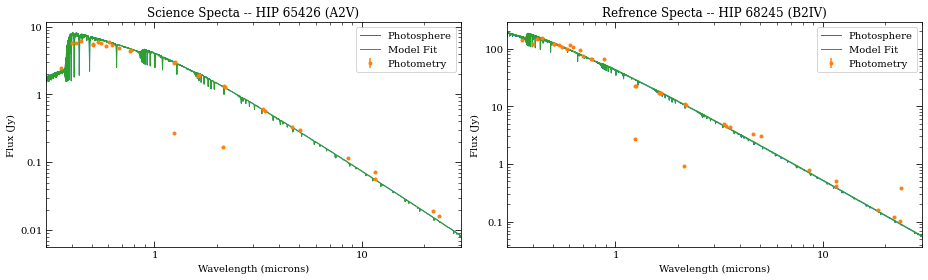

In [19]:
# Plot spectra 
fig, axes = plt.subplots(1,2, figsize=(13,4))
src.plot_SED(xr=[0.3,30], ax=axes[0])
ref.plot_SED(xr=[0.3,30], ax=axes[1])

axes[0].set_title('Science Specta -- {} ({})'.format(src.name, spt_sci))
axes[1].set_title('Refrence Specta -- {} ({})'.format(ref.name, spt_ref))

fig.tight_layout()

## Define Observations

In [27]:
from pynrc.nb_funcs import make_key, obs_wfe

image_mask = 'MASK335R'
pupil_mask = 'CIRCLYOT'
filter_list = ['F250M', 'F300M', 'F410M', 'F356W', 'F444W']
filter_list = ['F444W']

filt_list = []
all_keys = []
for f in filter_list:
    filt_list.append([f, image_mask, pupil_mask])
    all_keys.append(make_key(f, mask=image_mask, pupil=pupil_mask))

In [28]:
wfe_drift = 0
nrc_list = obs_wfe(wfe_drift, filt_list, sp_sci, dist_sci, sp_ref=sp_ref)

F444W_MASK335R_CIRCLYOT
